# Data preparation:

## Setting up:

In [62]:
# run script that installs missing libraries
#! chmod 755 ../scripts.sh
#! ../scripts.sh

In [3]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from process_pangeo import *
from re import search
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [4]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [5]:
def listFilesGC(pathGC, VAR):
    # Get all files already on GC in a bucket
    filesGC = []
    for blob in storage_client.list_blobs(bucket, prefix=pathGC):
        file_ = str(blob)
        if search(f'{VAR}_', file_):
            span = search(f"{VAR}_ant(.*?).nc", file_).span(0)
            filesGC.append(file_[span[0]:span[1]])
    return filesGC

#pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
# Download single file
def downloadFileFromGC(pathGC, pathLocal, fileGC):
    # Download from GC locally
    blob = bucket.blob(pathGC + fileGC)
    blob.download_to_filename(pathLocal+fileGC)

# Download multiple files    
def downloadFilesFromGC(pathGC, pathLocal, filesGC):
    N = len(filesGC)
    for i in tqdm(range(N)):
        file_name = filesGC[i]
        downloadFileFromGC(pathGC, pathLocal, file_name)
        
# Upload single files  
def uploadFileToGC(pathGC, fileGC):
    # upload to google cloud:
    blob = bucket.blob(pathGC+fileGC)
    blob.upload_from_filename(fileGC)
    
# Upload multiple files  
def uploadFilesToGC(pathGC, filesGC):
    N = len(filesGC)
    for i in tqdm(range(N)):
        # upload to google cloud:
        file_name = filesGC[i]
        blob = bucket.blob(pathGC+file_name)
        blob.upload_from_filename(file_name)
        
def filesInDir(pathLocal):
    return sorted([f for f in listdir(pathLocal) if isfile(join(pathLocal, f))])

def empty_dir(pathLocal):
  # delete all files as precaution
  for file_name in os.listdir(pathLocal):
    # construct full file path
    file = pathLocal + file_name
    if os.path.isfile(file):
        os.remove(file)
        
def filesInDirWithVar(pathLocal, VAR):
    files = filesInDir(pathLocal)
    filesWithVar = []
    for f in files:
        if search(f'{VAR}_', f):
            filesWithVar.append(f)
    return filesWithVar

In [6]:
def resampleMonthlyMean(array):
    Monthly = array.resample(time='1M').mean()
    # keep attrs info, ow lost
    Monthly.attrs = array.attrs
    for var in list(Monthly.keys()):
        Monthly[var].attrs = array[var].attrs
    return Monthly

In [7]:
def plotAllVar(GCM_xy, m=3, n=3, name='GCM'):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=0).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines()
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')
    
def KmtoM(RCM_xy):
    # Convert RCM from km to m for plots:
    RCM_xy['x'] = RCM_xy.x*1000
    RCM_xy['y'] = RCM_xy.y*1000
    RCM_xy.x.attrs['units'] = 'm'
    RCM_xy.y.attrs['units'] = 'm'
    return RCM_xy

def BasicPreprocRCM(RCMxy):
    RCMxy = RCMxy.rename({'X':'x', 'Y':'y','TIME':'time'})

    # indicate projection crs
    RCMxy = RCMxy.rio.write_crs("epsg:3031")

    # change km to m
    RCMxy = KmtoM(RCMxy)
    return RCMxy

## Read data:

GCM_xy### Monthly GCM xy: 
GCM projected from lat/lon to polar stereographic coordinates. 

#### Vars GCM:

For precipitation conversion: 1 kg/m2/s = 86400 mm/day.
Pressure level: near surface --> 925 Hpa

- **pr**: precipitation [kg m-2 s-1] --> need to change to  [mmWE/day], eq: **RF**
- **psl**: sea level pressure [Pa] --> need to change to [hPa], eq: **SP**
- **rlut**: outgoing longwave radiation [W/m2], eq: **LWD**
- **rsut**: outgoing shortwave radiation [W/m2], eq: **SWD**
- rsdt: incident shortwave radiation [W/m2]
- **tas**: near surface air temp [K] --> need to change to [°C], eq: **TT**
- **uas**: eastward near surface wind [m/s], eq: **UUP** at surface pressure (PLEV:7)
- **vas**: northward near surface wind [m/s], eq: **VVP** at surface pressure (PLEV:7)


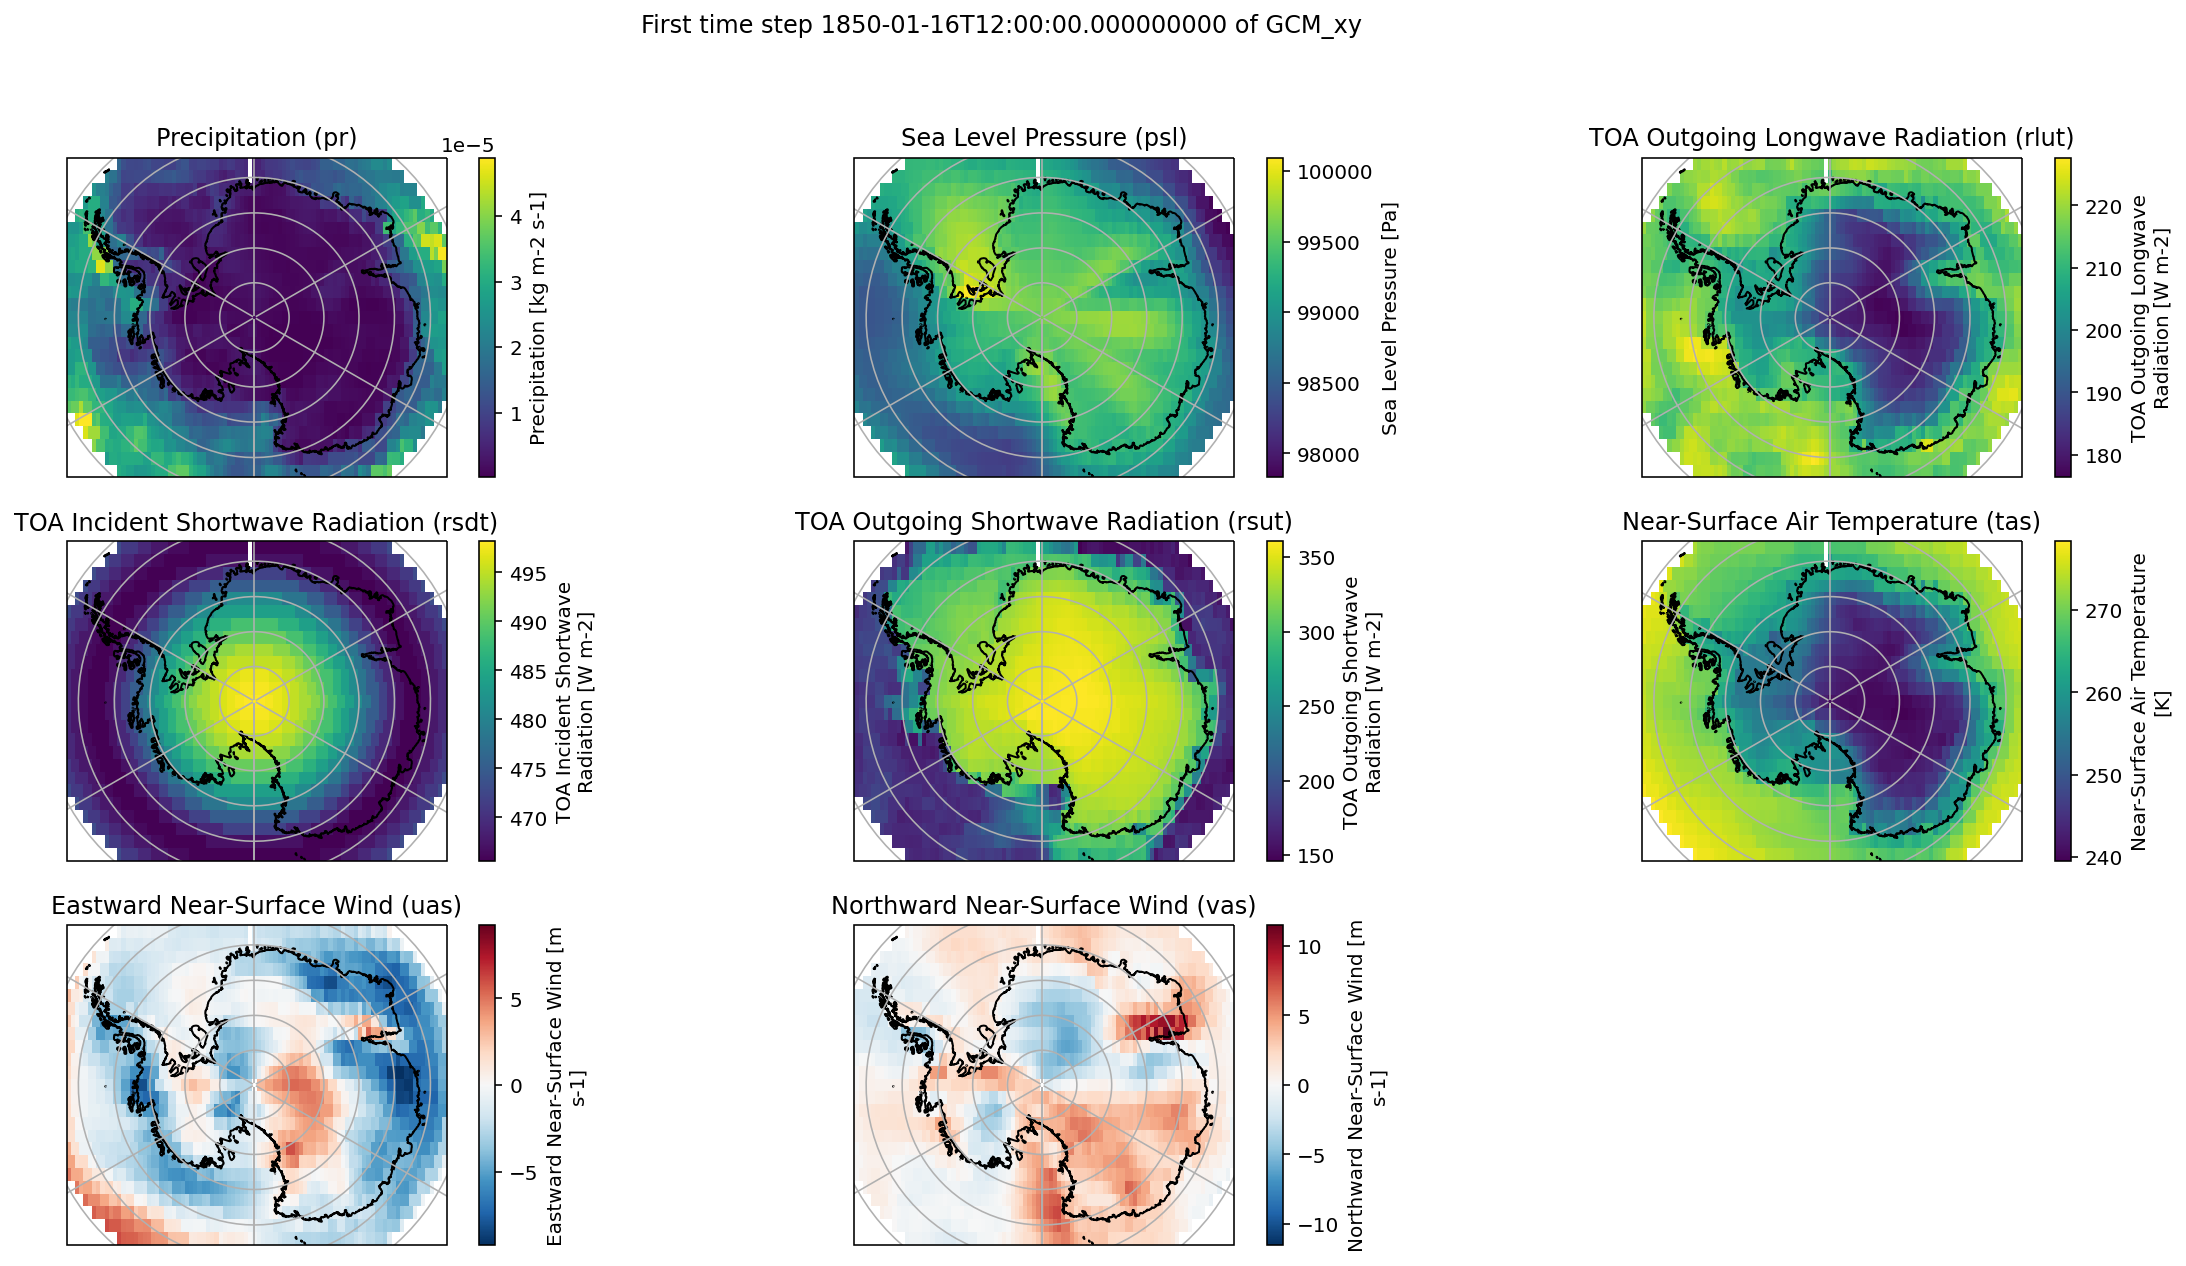

In [8]:
# open from google cloud
pathSave = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/monthly/month_ACCESS1-3-stereographic.zarr'        
GCM_xy = xr.open_zarr('gs://'+pathSave)
GCM_xy_plot = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','spatial_ref'])
plotAllVar(GCM_xy_plot, m=3, n=3, name='GCM_xy')

### RCM xy:
#### Vars RCM: 

PLEVLS: [200., 500., 600., 700., 800., 850., 925.]

ATMLAY: [0.99892 , 0.999325, 0.99973]

Atmosphere: 
- CC: Cloud Cover
- QQP: Specific Humidity [g/kg] (for 7 PLEV)
- RH: Relative Humidity [%] (ATMLAY: 3)

Water mass processes: 
- ME: Meltwater production [mmWE/day] (SECTOR1_1: 1)
- **RF**: Rainfall [mmWE/day] -> [mm/day]
- RU: Run-off of meltwater and rain water [mmWE/day] (SECTOR: 1)
- SF: Snowfall [mmWE/day]
- SMB: Surface Mass Balance (SMB~SF+RF-RU-SU-SW) [mmWE/day] (SECTOR: 1)
- SU: Sublimation and evaporation [mmWE/day] (SECTOR: 1)

Temperature: 
- **TT**: Temperature [°C] (ATMLAY:1, 0.9997)
- TTP: Temperature [°C] (PLEV: 7)

Pressure: 
- **SP**: Surface Pressure [hPa]

Radiation: 
- **SWD**: Short Wave Downward [W/m2]
- **LWD**: Long  Wave Downward [W/m2]

Wind speeds:
- **UUP**: x-Wind Speed component [m/s] (PLEV: 7)
- **VVP**: y-Wind Speed component [m/s] (PLEV: 7)

In [9]:
def ProcessRCMVar(var, RCM):
    if var == 'TT':
        # drop atmlay coordinate as singular
        dim = ('TIME', 'Y', 'X')
        RCM['TT'] = xr.Variable(dims = dim, 
                                    data = RCM.TT.mean(dim='ATMLAY'), 
                                    attrs = RCM.TT.attrs)
        RCM = RCM.drop_dims(['ATMLAY'])
        RCM = RCM.drop(['TIME_bnds'])
        return RCM
    if var == 'UUP':
        RCM = RCM.isel(PLEV=0).drop(['TIME_bnds','PLEV_bnds'])
        return RCM
    if var == 'VVP':
        RCM = RCM.isel(PLEV=0).drop(['TIME_bnds','PLEV_bnds'])
        return RCM
    else:
        return RCM.drop(['TIME_bnds'])

In [11]:
def pathToFiles(VAR, date1='19800101', date2='19801231'):
    pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
    fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_{date1}-{date2}.nc'
    return pathGC, fileGC

#### One time step:

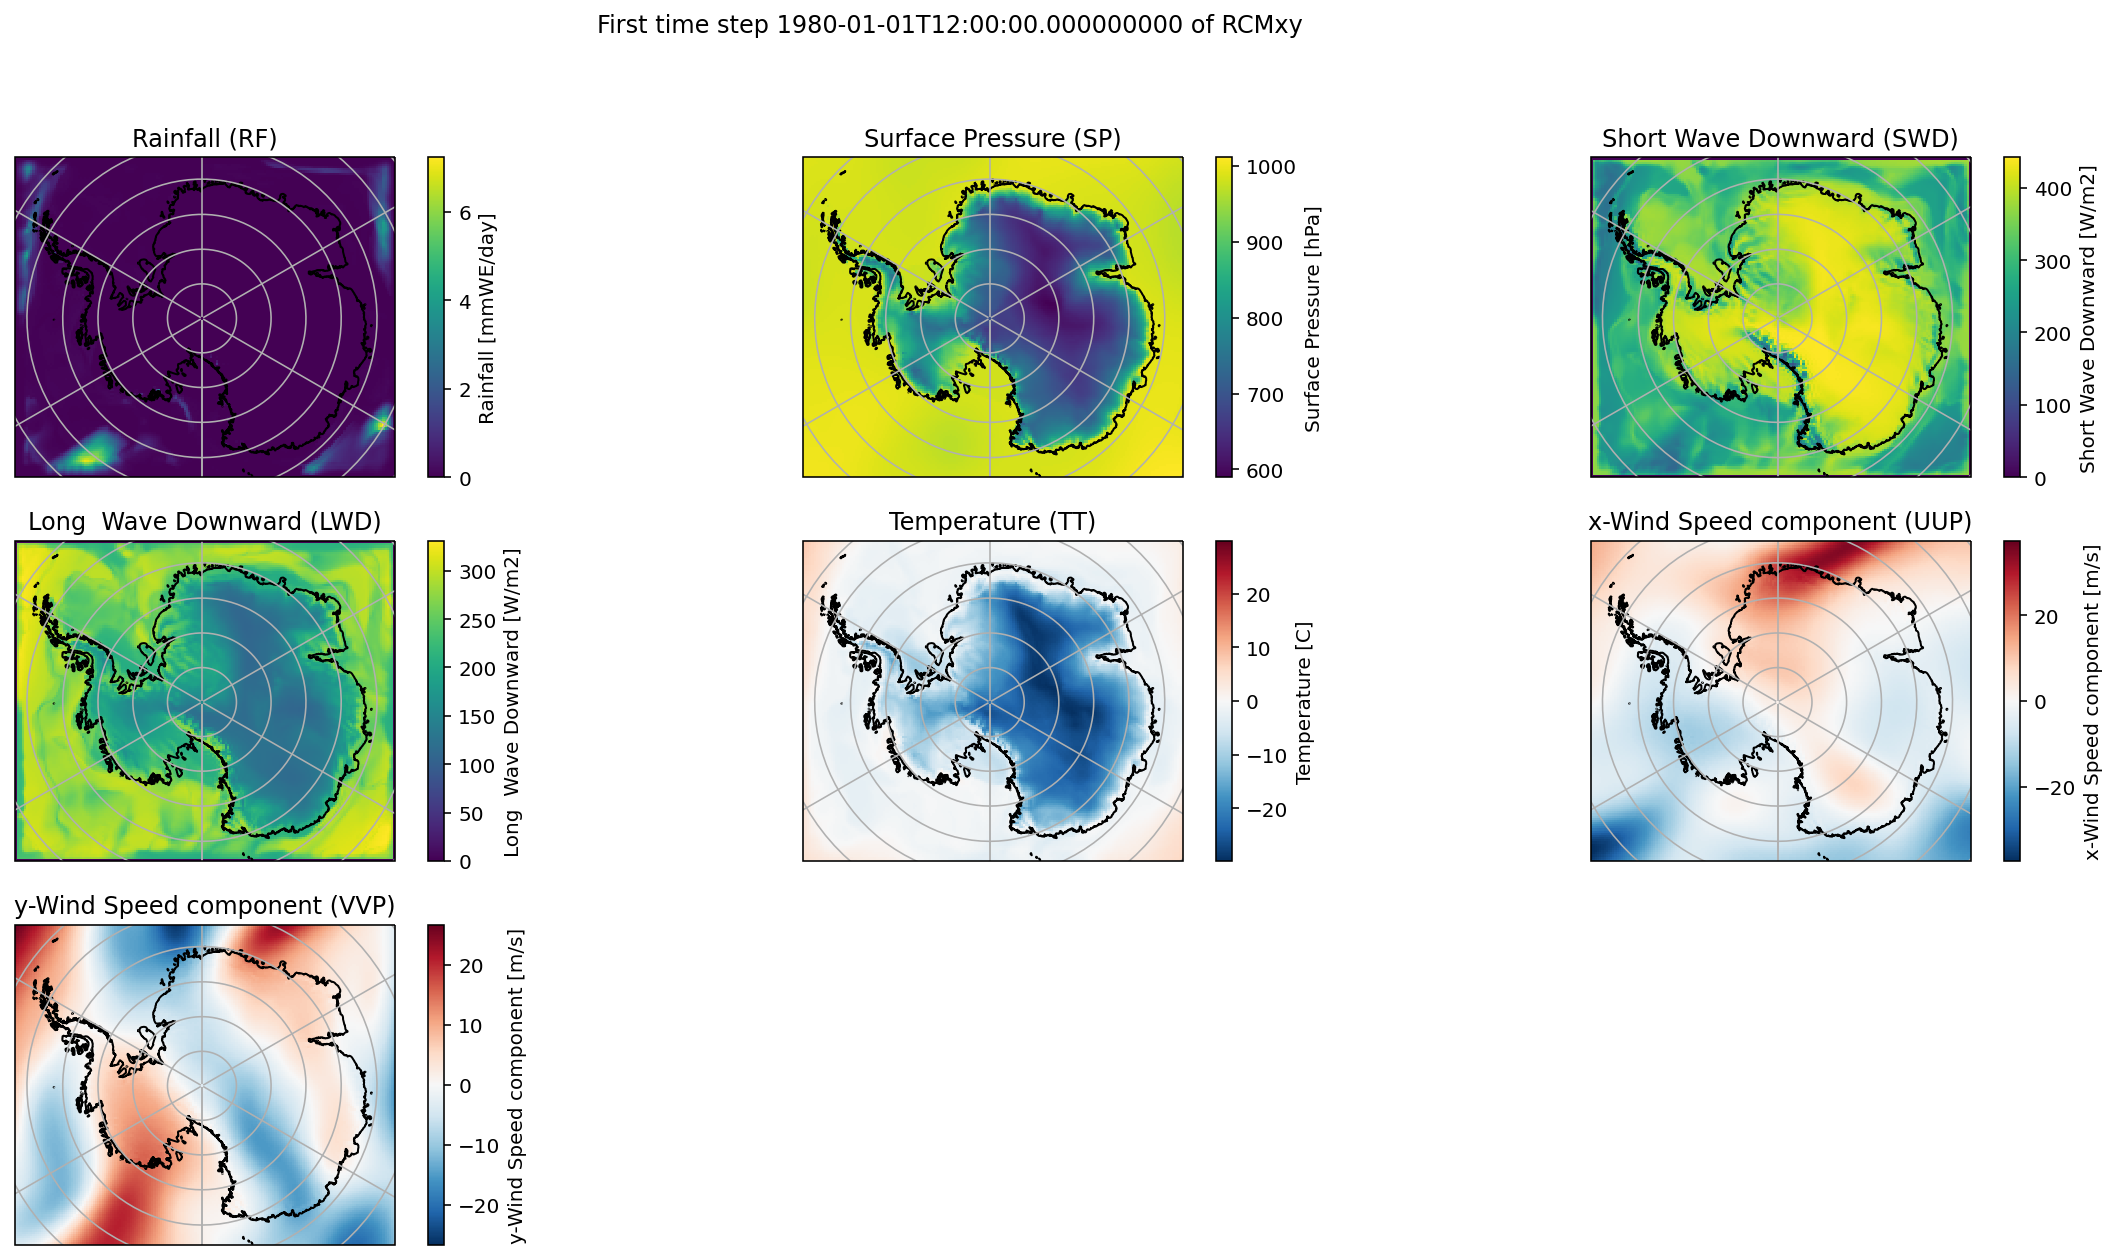

In [12]:
# Select variables that are also in GCM: 

# precipitation: 
VAR = 'RF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
rf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

# sea level pressure: 
VAR = 'SP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

# radiations:
VAR = 'SWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
swd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))


VAR = 'LWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
lwd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

# near surface air temp:
VAR = 'TT'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
tt = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

# wind at surface level (PLEV:0)
VAR = 'UUP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
uup = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
vvp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))

# Put together all variables:
RCMxy = xr.merge([rf, sp, swd, lwd, tt, uup, vvp])

# Basic pre-processing
RCMxy = BasicPreprocRCM(RCMxy)

plotAllVar(RCMxy, m=3, n=3, name='RCMxy')

## Preprocessing: 

### RCM 
#### Resample to monthly freq and save:

In [58]:
vars_ = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP']

for VAR in vars_:
    print(f'{VAR}:\n--------------')
    pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
    pathLocal = '../../data/tmp/'
    filesGC = listFilesGC(pathGC, VAR)
    
    #------ Download files from GC
    print('Downloading files from GC')
    downloadFilesFromGC(pathGC, pathLocal, filesGC)
    
    onlyfiles = filesInDirWithVar(pathLocal, VAR)
    print('Examples of files: \n {}'.format(onlyfiles[0]))

    #------ concatenate all years of a variable
    # first year
    print('Concatenating...')
          
    if len(onlyfiles) == 121:
        f0 = onlyfiles[0]
        df0 = xr.open_dataset(pathLocal+f0)
        # preprocessing and resampling
        df0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df0)))

        for f in onlyfiles[1:]:
            df = xr.open_dataset(pathLocal+f0)
            # preprocessing and resampling
            df = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df)))

            # concatenate with previous years
            df0 = xr.concat([df0,df], dim = 'time')

        # save file locally:
        path = '../../data/toGC/'
        name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc'
        df0.to_netcdf(name)

        # upload to GC:
        print('Uploading to GC...')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
        uploadFileToGC(pathGC, name)

        # delete file and temporary directory:
        os.remove(name)
        ! rm ../../data/tmp/*
          
    else:
        print(f'Error: len only files is:{len(onlyfiles) }')

RF:
--------------


100%|██████████| 121/121 [01:09<00:00,  1.75it/s]


Examples of files: 
 RF_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
SP:
--------------


100%|██████████| 121/121 [01:27<00:00,  1.38it/s]


Examples of files: 
 SP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
LWD:
--------------


100%|██████████| 121/121 [01:25<00:00,  1.41it/s]


Examples of files: 
 LWD_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
SWD:
--------------


100%|██████████| 121/121 [01:32<00:00,  1.31it/s]


Examples of files: 
 SWD_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
TT:
--------------


100%|██████████| 121/121 [01:40<00:00,  1.20it/s]


Examples of files: 
 TT_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
UUP:
--------------


100%|██████████| 121/121 [08:13<00:00,  4.08s/it]


Examples of files: 
 UUP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...
VVP:
--------------


100%|██████████| 121/121 [06:35<00:00,  3.27s/it]


Examples of files: 
 VVP_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc
Concatenating...
Uploading to GC...


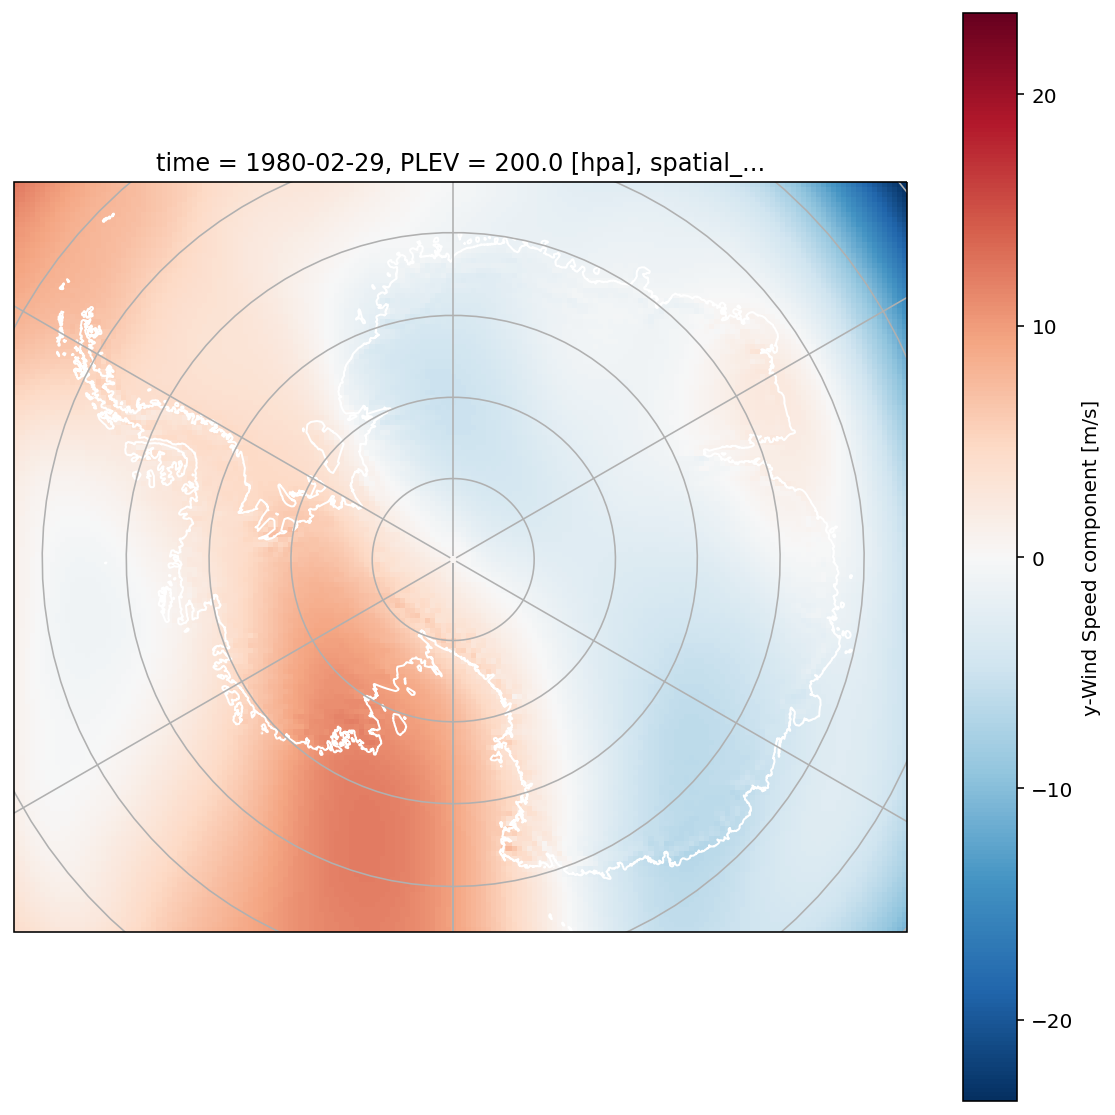

In [60]:
# test:
f = plt.figure(figsize=(10, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
df0.isel(time = 1).VVP.plot(ax=ax, x='x', y='y',transform=ccrs.SouthPolarStereo())
ax.coastlines('10m', color='white')
ax.gridlines()

#### Concatenate all variables:

In [68]:
vars_ = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP']
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
pathLocal = '../../data/tmp/'

# names of files on GC
filesGC = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc' for VAR in vars_]

# download files and store locally
downloadFilesFromGC(pathGC, pathLocal, filesGC)


100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


In [ ]:
files

In [ ]:

for VAR in vars_: 
    pathLocal = '../../data/tmp/'
    
    #------ Download files from GC
    print('Downloading files from GC')
    downloadFilesFromGC(pathGC, pathLocal, filesGC)

#### (Closer look at winds):

In [ ]:
VAR = 'VVP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels.VVP<90)
upper = vvplevels.where(vvplevels.VVP>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels.VVP.isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'VVP_plvl_{level+1}_lower'] = lower.VVP.isel(PLEV=level)
    vvplevels[f'VVP_plvl_{level+1}_upper'] = upper.VVP.isel(PLEV=level)

vvplevels = vvplevels.drop(['VVP','TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')

In [ ]:
VAR = 'UUP'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
fileGC = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_day_19800101-19801231.nc'
vvplevels = xr.open_dataset(fileGC)
vvplevels = vvplevels.rename({'X':'x', 'Y':'y','TIME':'time'})

lower = vvplevels.where(vvplevels[VAR]<90)
upper = vvplevels.where(vvplevels[VAR]>90)

for i in range(2):
    vvplevels[f'VVP_plvl_{i+1}'] = vvplevels[VAR].isel(PLEV=i)

for level in [2, 3,4,5,6]:
    vvplevels[f'{VAR}_plvl_{level+1}_lower'] = lower[VAR].isel(PLEV=level)
    vvplevels[f'{VAR}_plvl_{level+1}_upper'] = upper[VAR].isel(PLEV=level)

vvplevels = vvplevels.drop([VAR,'TIME_bnds','PLEV_bnds'])
vvplevels = KmtoM(vvplevels)

vars_ = list(vvplevels.data_vars)
coords = list(vvplevels.coords)
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.SouthPolarStereo())
    vvplevels[var].isel(time=0).plot(ax=ax, x='x', y='y',
            transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'{var}')
plt.suptitle(f'First time step of {vvplevels[var].long_name}')

### GCM:
So that is similar to RCM

In [ ]:
# open from google cloud
pathSave = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/monthly/month_ACCESS1-3-stereographic.zarr'        
GCM_xy = xr.open_zarr('gs://'+pathSave)
GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

# Slice to same time as RCM:
Firstdate = datetime(1980,1,16, 12, 0,0)
Enddate = datetime(2100,12,16, 12, 0,0)

GCM_xy = GCM_xy.sel(time = slice(Firstdate, Enddate))
GCM_xy = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','rsdt'])

# change prec to right units (mmWE/day): 
var = 'pr'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*86400, 
                            attrs = RCMxy.RF.attrs)

# change pressure from pa to hpa: 1pa = 0.01 hPa 
var = 'psl'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*0.01, 
                            attrs = RCMxy.SP.attrs)

# change temperature from K to C: 1K = -272,15 °C 
var = 'tas'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]-272.15, 
                            attrs = RCMxy.TT.attrs)
GCM_xy

In [ ]:
plotAllVar(GCM_xy, m=3, n=3, name='GCM_xy')